# 성능 최적화 종합실습 : Car seat sales
유아용 카시트 매출액을 예측해 봅시다.

* 카시트에 대해서 지역 매장 별 매출액을 예측하고자 합니다.

![](https://cdn.images.express.co.uk/img/dynamic/24/590x/child-car-seat-986556.jpg?r=1532946857754)

## 1.환경준비

### (1) Import

In [1]:
#라이브러리들을 불러오자.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 전처리
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# 모델링
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import * 

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import warnings
warnings.filterwarnings(action='ignore')

### (2) 함수 생성

* 선형회귀용 전진선택법

In [2]:
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant

def forward_stepwise_linear(x_train, y_train):

    # 변수목록, 선택된 변수 목록, 단계별 모델과 AIC 저장소 정의
    features = list(x_train)
    selected = []
    step_df = pd.DataFrame({ 'step':[], 'feature':[],'aic':[]})

    # 
    for s in range(0, len(features)) :
        result =  { 'step':[], 'feature':[],'aic':[]}

        # 변수 목록에서 변수 한개씩 뽑아서 모델에 추가
        for f in features :
            vars = selected + [f]
            x_tr = x_train[vars]
            model = OLS(y_train, add_constant(x_tr)).fit(disp=False)
            result['step'].append(s+1)
            result['feature'].append(vars)
            result['aic'].append(model.aic)
        
        # 모델별 aic 집계
        temp = pd.DataFrame(result).sort_values('aic').reset_index(drop = True)

        # 만약 이전 aic보다 새로운 aic 가 크다면 멈추기
        if step_df['aic'].min() < temp['aic'].min() :
            break
        step_df = pd.concat([step_df, temp], axis = 0).reset_index(drop = True)

        # 선택된 변수 제거
        v = temp.loc[0,'feature'][s]
        features.remove(v)

        selected.append(v)
    
    # 선택된 변수와 step_df 결과 반환
    return selected, step_df

* 변수 중요도 그래프

In [3]:
def plot_feature_importance(importance, names):
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_df.reset_index(drop=True, inplace = True)

    plt.figure(figsize=(10,8))
    sns.barplot(x='feature_importance', y='feature_names', data = fi_df)

    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    plt.grid()

    return fi_df

### (3) Data Loading

In [4]:
data_path = 'https://raw.githubusercontent.com/DA4BAM/dataset/master/Carseats.csv'
data = pd.read_csv(data_path)

**변수설명**
> * Sales - 각 지역 판매량(단위 : 1000개) <== Target
* CompPrice - 각 지역 경쟁사 가격
* Income - 각 지역 평균 소득수준(단위 : 1000달러)
* Advertising - 각 지역, 회사의 광고 예산(단위 : 1000달러)
* Population - 지역 인구수(단위 : 1000명)
* Price - 자사 지역별 판매가격
* ShelveLoc - 진열상태
* Age - 지역 인구의 평균 연령
* Education - 각 지역 교육수준 레벨
* Urban - 매장 도시 지역 여부
* US - 매장이 미국에 있는지 여부

## 2.데이터 이해

* 둘러보기

In [5]:
data.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


## 3.데이터 준비

### (1) 데이터 정리

In [6]:
data['Diff_Price'] = data['CompPrice'] - data['Price']
data.drop('CompPrice', axis = 1, inplace = True)

### (2) 데이터분할1 : x, y 나누기

In [7]:
target = 'Sales'
x = data.drop(target, axis = 1)
y = data.loc[:, target]

### (3) NA 조치

### (4) 가변수화

In [8]:
dumm_cols = ['ShelveLoc','Education','Urban', 'US']
x = pd.get_dummies(x, columns = dumm_cols, drop_first = True)

### (5) 데이터분할2 : train : validation 나누기

In [9]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=.3, random_state = 2022)

### (6) Scaling
KNN 알고리즘을 적용하기 위해서는 스케일링을 해야 합니다.

In [10]:
scaler = MinMaxScaler()
x_train_s = scaler.fit_transform(x_train)
x_val_s = scaler.transform(x_val)

## 4.모델링



### (1) 선형회귀

In [11]:
selected, step_df = forward_stepwise_linear(x_train, y_train)

In [12]:
selected

['Diff_Price',
 'ShelveLoc_Good',
 'ShelveLoc_Medium',
 'Advertising',
 'Age',
 'Income',
 'Education_15']

In [13]:
step_df

,step,feature,aic
0,1.0,[Diff_Price],1249.425785
1,1.0,[ShelveLoc_Good],1293.984969
2,1.0,[Price],1313.653507
3,1.0,[Advertising],1339.527338
4,1.0,[Income],1350.602386
...,...,...,...
100,7.0,"[Diff_Price, ShelveLoc_Good, ShelveLoc_Medium,...",815.558798
101,7.0,"[Diff_Price, ShelveLoc_Good, ShelveLoc_Medium,...",815.757990
102,7.0,"[Diff_Price, ShelveLoc_Good, ShelveLoc_Medium,...",815.792453
103,7.0,"[Diff_Price, ShelveLoc_Good, ShelveLoc_Medium,...",815.829438


In [14]:
model1 = LinearRegression()
model1.fit(x_train[selected], y_train)
pred1 = model1.predict(x_val[selected])

pred1

array([ 6.73543142,  7.55423209, 10.31578363,  7.91931922,  5.27465532,
        6.08530063,  5.14870985,  4.95809081,  4.43507215,  5.20966652,
        5.42595331,  1.08465183,  5.00166259,  7.06745647,  8.39252555,
        7.75479382,  4.05189935,  6.87657612,  3.93708532,  5.99027985,
        7.37240574,  7.60069371,  6.35693451,  5.72326167,  3.47383267,
       10.3544791 ,  7.34336612,  8.06614411,  6.85964865,  6.40581519,
        9.96775324,  4.72972249,  6.4528839 , 10.46286925,  6.96269626,
       13.23504945,  9.64515639,  8.1009044 ,  8.50964299,  9.66196001,
        5.3055281 ,  6.32869984,  6.71139821,  4.72137041,  7.52715872,
       10.64907028,  4.84893888,  6.66733898, 11.00460244, 10.87846652,
       14.09458255, 11.4776057 , 13.01833593,  5.78661334,  7.56023142,
       11.6775497 ,  8.87014333, 11.36759054,  9.97907106,  8.43108375,
        5.38189898,  5.84990312,  8.02619871,  6.13571647,  4.54721528,
        8.20707133,  5.93849156,  5.71977635,  5.22644803,  8.36

In [16]:
# 제공된 함수와 비교해 봅시다.
r2_score(y_val, pred1)

0.8801970769167834

In [17]:
# MSE
mean_squared_error( y_val   , pred1   ) 

1.0422153386262976

In [18]:
# RMSE
mean_squared_error( y_val   , pred1  , squared = False)

1.020889484041391

In [19]:
# MAE
mean_absolute_error(y_val   , pred1   )

0.8014365161361277

In [20]:
# MAPE : 원래 개념은 100(%)을 곱해야 한다. 그렇지만 sklearn 함수는 100 안 곱한채로 결과를 준다.
mean_absolute_percentage_error(y_val   , pred1  )

0.20785310360108084

In [21]:
# 1 - MAPE : 회귀모델의 정확도
1 -  mean_absolute_percentage_error(y_val   , pred1   )
# MAPE > 1 보다 크면 - 값이 나오므로 정확하지 않을수있다.

0.7921468963989191

### (2) KNN

In [86]:
model2 = KNeighborsRegressor()

In [87]:
x_train.shape

(280, 18)

In [88]:
import math
math.sqrt(280)

16.73320053068151

In [89]:
params2 = {'n_neighbors' : range(1, 101, 5)}

In [90]:
model2_gs = GridSearchCV(model2, params2, cv=5)

In [91]:
model2_gs.fit(x_train_s, y_train)

GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': range(1, 101, 5)})

In [92]:
model2_gs.best_params_

{'n_neighbors': 21}

In [93]:
model2_gs.best_score_

0.3256539261515736

In [94]:
result = pd.DataFrame(model2_gs.cv_results_)

In [95]:
temp = result.loc[:, ['param_n_neighbors','mean_test_score']]
temp.head()

,param_n_neighbors,mean_test_score
0,1,-0.094664
1,6,0.285907
2,11,0.306238
3,16,0.310454
4,21,0.325654


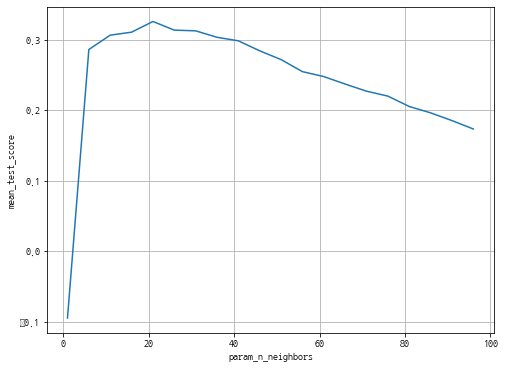

In [96]:
plt.figure(figsize = (8,6))
sns.lineplot(x = 'param_n_neighbors', y = 'mean_test_score', data = temp )
plt.grid()
plt.show()

In [30]:
pred2 = model2_gs.predict(x_val_s)

In [31]:
pred2

array([ 7.4135,  8.1045, 10.215 ,  7.225 ,  6.3875,  7.1525,  6.7665,
        8.094 ,  6.741 ,  6.5255,  7.0655,  6.426 ,  6.976 ,  9.5555,
        7.329 ,  7.567 ,  5.8065,  6.939 ,  7.0245,  7.2955,  7.488 ,
        6.8585,  7.246 ,  7.11  ,  6.6135,  8.739 ,  8.276 ,  7.211 ,
        7.4855,  5.9075,  8.4   ,  6.5475,  7.602 , 10.101 ,  7.2445,
        8.257 ,  8.131 ,  8.388 ,  9.31  ,  8.916 ,  6.9565,  8.1345,
        7.9075,  6.4   ,  7.5605,  8.484 ,  8.2765,  6.9775,  7.958 ,
       10.0545, 11.248 ,  9.372 , 10.7305,  7.0885,  8.028 ,  8.4085,
        7.216 ,  9.9245,  7.988 ,  8.0675,  7.341 ,  7.6485,  7.623 ,
        7.3305,  6.4755,  7.688 ,  7.3475,  6.881 ,  7.2785,  9.8635,
        6.6115,  7.0775,  7.6095, 10.068 ,  7.3025,  6.908 ,  8.139 ,
        7.4455,  8.016 ,  7.3945,  7.223 ,  9.9355,  7.236 ,  6.8965,
        7.22  ,  6.8945, 10.8725,  7.1555,  7.56  ,  8.664 ,  7.851 ,
        7.5705,  7.692 ,  8.249 ,  7.576 ,  6.634 ,  7.373 ,  6.6885,
        6.7285,  9.5

### (3) Decision Tree

In [32]:
model3 = DecisionTreeRegressor()

In [33]:
params3 = {'max_depth' : range(1, 11), 'min_samples_leaf' : range(10, 101)}

In [34]:
model3_gs = GridSearchCV(model3, params3, cv=5, scoring = 'neg_mean_absolute_error')

In [35]:
model3_gs.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': range(1, 11),
                         'min_samples_leaf': range(10, 101)})

In [36]:
model3_gs.best_params_

{'max_depth': 7, 'min_samples_leaf': 10}

In [37]:
model3_gs.best_score_

0.5181351298523645

In [38]:
pred3 = model3_gs.predict(x_val_s)

In [39]:
pred3

array([8.08857143, 3.444     , 8.26941176, 8.08857143, 5.685     ,
       8.08857143, 3.444     , 5.685     , 3.444     , 7.05      ,
       5.685     , 5.685     , 3.444     , 8.26941176, 7.05      ,
       8.08857143, 3.444     , 5.685     , 3.444     , 7.05      ,
       5.685     , 7.05      , 5.685     , 3.444     , 5.685     ,
       8.26941176, 5.685     , 8.08857143, 5.685     , 7.05      ,
       8.26941176, 5.685     , 7.05      , 8.26941176, 7.05      ,
       8.26941176, 5.685     , 8.26941176, 8.26941176, 8.26941176,
       7.05      , 8.26941176, 5.685     , 5.685     , 8.08857143,
       8.26941176, 8.26941176, 8.08857143, 8.08857143, 8.26941176,
       8.26941176, 8.08857143, 8.26941176, 5.685     , 5.685     ,
       8.26941176, 8.08857143, 8.26941176, 8.08857143, 8.08857143,
       5.685     , 5.685     , 8.08857143, 8.08857143, 3.444     ,
       5.685     , 7.05      , 5.685     , 3.444     , 8.26941176,
       3.444     , 5.685     , 7.05      , 8.26941176, 8.08857

### (4) SVM

In [46]:
model4 = SVR()

In [47]:
params4 = {'C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000], 'gamma' : [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}

In [48]:
model4_gs = GridSearchCV(model4, params4, cv=5)

In [49]:
model4_gs.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=SVR(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
                         'gamma': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]})

In [50]:
model4_gs.best_params_

{'C': 1, 'gamma': 0.001}

In [51]:
model4_gs.best_score_

0.10163116168415065

In [52]:
pred4 = model4_gs.predict(x_val_s)

In [53]:
pred4

array([7.73582008, 7.73582172, 7.7358247 , 7.73582097, 7.7358241 ,
       7.73581963, 7.73582733, 7.73582269, 7.73582757, 7.73582843,
       7.73582708, 7.73581854, 7.73582682, 7.73582127, 7.73582326,
       7.735822  , 7.73582682, 7.73582869, 7.73582302, 7.73582232,
       7.7358181 , 7.73582722, 7.73581924, 7.73581729, 7.73582312,
       7.73581831, 7.73582829, 7.73582665, 7.7358272 , 7.73582804,
       7.73581494, 7.73581577, 7.73582964, 7.73582399, 7.73582753,
       7.73582221, 7.73582275, 7.73582447, 7.73581818, 7.73582195,
       7.73582939, 7.73583105, 7.73581272, 7.73582648, 7.73581792,
       7.73582315, 7.73582719, 7.73582516, 7.7358239 , 7.73581948,
       7.73581875, 7.7358241 , 7.73582629, 7.7358272 , 7.73581435,
       7.73582561, 7.73582121, 7.73583037, 7.73581761, 7.73581843,
       7.7358186 , 7.73582931, 7.73582532, 7.73583192, 7.73583231,
       7.73582541, 7.73581821, 7.7358203 , 7.73581841, 7.73582151,
       7.73582702, 7.73582025, 7.73583018, 7.73581834, 7.73582

### (5) Random Forest

In [54]:
model5 = RandomForestRegressor()

In [55]:
params5 = {'n_estimators': range(5, 201, 20), 'max_features': range(1, 11)}

In [56]:
model5_gs = GridSearchCV(model5, params5, cv=5)

In [57]:
model5_gs.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_features': range(1, 11),
                         'n_estimators': range(5, 201, 20)})

In [58]:
model5_gs.best_params_

{'max_features': 10, 'n_estimators': 165}

In [59]:
model5_gs.best_score_

0.7337074623527926

In [60]:
pred5 = model4_gs.predict(x_val_s)

In [61]:
pred5

array([7.73582008, 7.73582172, 7.7358247 , 7.73582097, 7.7358241 ,
       7.73581963, 7.73582733, 7.73582269, 7.73582757, 7.73582843,
       7.73582708, 7.73581854, 7.73582682, 7.73582127, 7.73582326,
       7.735822  , 7.73582682, 7.73582869, 7.73582302, 7.73582232,
       7.7358181 , 7.73582722, 7.73581924, 7.73581729, 7.73582312,
       7.73581831, 7.73582829, 7.73582665, 7.7358272 , 7.73582804,
       7.73581494, 7.73581577, 7.73582964, 7.73582399, 7.73582753,
       7.73582221, 7.73582275, 7.73582447, 7.73581818, 7.73582195,
       7.73582939, 7.73583105, 7.73581272, 7.73582648, 7.73581792,
       7.73582315, 7.73582719, 7.73582516, 7.7358239 , 7.73581948,
       7.73581875, 7.7358241 , 7.73582629, 7.7358272 , 7.73581435,
       7.73582561, 7.73582121, 7.73583037, 7.73581761, 7.73581843,
       7.7358186 , 7.73582931, 7.73582532, 7.73583192, 7.73583231,
       7.73582541, 7.73581821, 7.7358203 , 7.73581841, 7.73582151,
       7.73582702, 7.73582025, 7.73583018, 7.73581834, 7.73582

### (5) XGB

In [62]:
model6 = XGBRegressor(objective = 'reg:squarederror')

In [63]:
params6 = {'learning_rate':np.linspace(0.001,0.3,30), 
           'n_estimators':[20,30,50,100]}

In [64]:
model6_gs = GridSearchCV(model6, params6, cv=5)

In [65]:
model6_gs.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat...
             param_grid={'learning_rate': array([0.001     , 0.01131034, 0.02162069, 0.03193103, 0.04224138,
       0.05255172, 0.06286207, 0.07317241, 0.08348276, 0.0937931 ,
       0.10410345, 0.11441379, 0.12472414, 0.13503448, 0.14534483,
       0.1556

In [66]:
model6_gs.best_params_

{'learning_rate': 0.22782758620689655, 'n_estimators': 30}

In [67]:
model6_gs.best_score_

0.7249531869285823

In [68]:
pred6 = model5_gs.predict(x_val_s)

In [69]:
pred6

array([6.96042424, 5.90006061, 8.62812121, 6.88218182, 6.70284848,
       6.85448485, 5.75290909, 6.832     , 5.82484848, 6.06812121,
       6.81860606, 6.86775758, 5.86884848, 8.5849697 , 5.98987879,
       6.95248485, 5.76521212, 6.82909091, 5.93672727, 5.98987879,
       6.93169697, 6.0150303 , 6.90624242, 5.99212121, 6.81860606,
       8.21945455, 6.87860606, 6.82024242, 6.86169697, 5.88848485,
       8.53830303, 6.75812121, 5.98739394, 8.5849697 , 6.09581818,
       8.28206061, 6.80266667, 8.24393939, 8.68769697, 8.70587879,
       5.954     , 8.21945455, 6.93169697, 6.77993939, 7.12127273,
       8.20333333, 8.21945455, 7.03466667, 6.85448485, 8.68769697,
       8.62212121, 7.14818182, 8.62212121, 6.802     , 6.87981818,
       8.20333333, 6.91515152, 8.69890909, 6.96042424, 6.96109091,
       6.82909091, 6.97206061, 7.01381818, 7.06351515, 5.99212121,
       6.83775758, 5.92157576, 6.81860606, 5.92884848, 8.65115152,
       5.91006061, 6.802     , 6.06460606, 8.5749697 , 6.97872

In [97]:
model_name = ['LinearRegression', 'KNN', 'Decision Tree', 'SVM', 'Random Forest', 'XGB'] 
r2score, mse, rmse, mae, mape = [], [], [], [], []
pred = [pred1, pred2, pred3, pred4, pred5, pred6]

for i, p in enumerate(pred):
    r2score.append(r2_score(y_val, p))
    mse.append(mean_squared_error(y_val, p))
    rmse.append(mean_squared_error(y_val, p, squared = False))
    mae.append(mean_absolute_error(y_val, p)) 
    mape.append(mean_absolute_percentage_error(y_val, p)) 

result = pd.DataFrame({'model_name': model_name, 'r^2 score':r2score, 'mse': mse, 'rmse':rmse, 'mae':mae, 'mape':mape}) 
result

,model_name,r^2 score,mse,rmse,mae,mape
0,LinearRegression,0.880197,1.042215,1.020889,0.801437,0.207853
1,KNN,0.353301,5.625901,2.371898,1.962862,0.745133
2,Decision Tree,0.324848,5.873430,2.423516,1.858460,0.596661
3,SVM,-0.040160,9.048784,3.008120,2.493803,0.910092
4,Random Forest,-0.040160,9.048784,3.008120,2.493803,0.910092
5,XGB,0.278219,6.279072,2.505808,2.025201,0.731900


In [ ]:
GridSearchCV score

In [ ]:
https://scikit-learn.org/stable/modules/model_evaluation.html